
--- Laban's Space features ---
Directness index = 0.15840440996495378
Goodness of fit = 0.14872611767038035
Total Space score = 0.15356526381766705

--- Laban's Time features ---
Average normalized kinetic energy = 0.10849056603773588
Impulsiveness = 0.30145964066851305
Total Time score = 0.2821627332054354

 You are a cook mixing a soup!


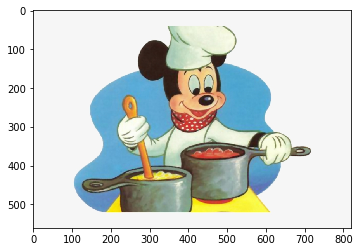


--- Laban's Space features ---
Directness index = 0.9961272260103462
Goodness of fit = 0.9989245207021437
Total Space score = 0.9975258733562449

--- Laban's Time features ---
Average normalized kinetic energy = 0.25633285984848486
Impulsiveness = 0.9943538190902922
Total Time score = 0.9205517231661114

 You are an airplane taking off!


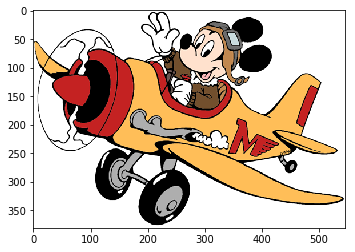

In [7]:
from tkinter import *
import PIL
from PIL import Image, ImageDraw
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn import linear_model
from sklearn.metrics import r2_score
from collections import deque
from playsound import playsound


### constants

# data capture framework
sampling_frequency = 1.0    # sampling frequency of the mouse
canvas_size = (640, 480)    # size in pixels of the canvas for collecting mouse data

# analysis framework
weights = np.array([
    [0.5, 0.5],            # weights for the Space features
    [0.1, 0.9]             # weights for the Time features
])
#enable_continuous_analysis = 1    # set it to 1 to enable analysis on a fixed time window, to 0 otherwise
#buffer_size = 10                  # size of the fixed time window used for the continuous analysis only


### global variables and data structures

gesture = list()
#buffer = deque([], buffer_size)   # used for continuous analysis only
#how_many = 0                      # used for continuous analysis only
#results = list()                  # used for continuous analysis only
lastx, lasty = None, None

def initialize():
    global gesture#, buffer, how_many, results
    gesture = []
    #for i in range(1, buffer_size):
    #    buffer.append((0,0))
    #how_many = 0
    #results = []
    return

def append(point):
    global gesture#, buffer, how_many
    gesture.append(point)     
    #buffer.appendleft(point)
    #how_many = how_many + 1
    return

#def append_result(data):
#    global results
#    results.append(data) 
#    return


### Laban analysis functions  

# Laban's Space
def get_distance(point1, point2):
    return np.linalg.norm(np.array(point2) - np.array(point1))

def path_length(points):
    length = 0
    for (i, j) in zip(points, points[1:]):
        length += get_distance(i, j)
    return length

def directness_index(points):
    return get_distance(points[0], points[-1]) / path_length(points)

def goodness_of_linear_fit(points):
    p = np.array(points)
    regr = linear_model.LinearRegression()
    x_coord = p[:, 0]
    y_coord = p[:, 1]
    x = x_coord.reshape(-1, 1)
    y = y_coord.reshape(-1, 1)
    regr.fit(x, y)
    y_pred = regr.predict(x)
    r2 = r2_score(y, y_pred)
    return r2

def laban_space(points, weights, canvas_size=(640, 480), display=0):
    s1 = directness_index(points)
    s2 = goodness_of_linear_fit(points)
    score = weights[0] * s1 + weights[1] * s2
    if (display == 1):
        print("\n--- Laban's Space features ---")
        print("Directness index =", s1)
        print("Goodness of fit =", s2)
        print("Total Space score =", score)
    return score

# Laban's Time
def speed(points, fs=1.0):
    dt = 1.0 / fs
    sp = []
    for (i, j) in zip(points, points[1:]):
        sp.append(np.linalg.norm([(j[0] - i[0]) / dt, (j[1] - i[1]) / dt]))
    return sp

def average_normalized_kinetic_energy(points, fs=1.0):
    sp = speed(points, fs)
    squares = np.square(sp)
    max_square = np.amax(squares)
    return np.mean(np.divide(squares, max_square))
        
def impulsiveness(points, fs=1.0):
    sp = speed(points, fs)
    m = np.amax(sp)
    d = len(sp)
    ratio = m / d
    if ratio < 1.0:
        return 0.5 * ratio
    else:
        return 1.0 / (1.0 + np.exp(-(ratio - 1.0)))

def laban_time(points, weights, fs=1.0, display=0):
    t1 = average_normalized_kinetic_energy(points)
    t2 = impulsiveness(points)
    score = weights[0] * t1 + weights[1] * t2
    if (display == 1):
        print("\n--- Laban's Time features ---")
        print("Average normalized kinetic energy =", t1)
        print("Impulsiveness =", t2)
        print("Total Time score =", score)
    return score

# Laban's analysis
def laban_analysis(data, weights, canvas_size=(640, 480), fs=1.0, display=0):
    if len(data) != 0:
        s = laban_space(data, weights[0,:], canvas_size, display)
        t = laban_time(data, weights[1,:], sampling_frequency, display)
        return s, t
    else:
        return -1, -1

    
def analyse_gesture():
    s, t = laban_analysis(gesture, weights, canvas_size, sampling_frequency, 1)
    if (s == -1 and t == -1):
        print("Warning: no data to analyze.")
        return
    r = which_character(s, t)
    synthesis(r)
    return r

def which_character(s, t):
    if s < 0.5 and t < 0.5:
        r="cook"
    elif s > 0.5 and t > 0.5:
        r="airplane"
    else:
        r="none"
    return r

def synthesis(character):
    if character == "cook":
        print("\n You are a cook mixing a soup!")
        img_cook = mpimg.imread('cook.png')
        plt.imshow(img_cook)
        plt.show()
        playsound("cook.wav")
    elif character == "airplane":
        print("\n You are an airplane taking off!")
        img_plane = mpimg.imread('plane.png')
        plt.imshow(img_plane)
        plt.show()
        playsound("plane.wav")
    else: 
        print("\n I am not sure about which character you mimicked. Could you please try again?")


### canvas and buttons handling functions

def create_widgets():
    deleteb = Button(cv, text = 'Delete', command = delete_image)
    deleteb.configure(width = 20)
    deleteb_window = cv.create_window(400, 450, anchor=CENTER, window=deleteb)

    labanb=Button(cv, text = 'Analysis', command = analyse_gesture)
    labanb.configure(width=20)
    labanb_window = cv.create_window(250, 450, anchor=CENTER, window=labanb)
    
    cv.bind('<1>', activate_paint)
    cv.pack(expand=YES, fill=BOTH)
    return

def activate_paint(e):
    global lastx, lasty
    cv.bind('<B1-Motion>', paint)
    lastx, lasty = e.x, e.y
    return

def paint(e):
    global lastx, lasty
    x, y = e.x, e.y
    cv.create_line((lastx, lasty, x, y), width=1)
    draw.line((lastx, lasty, x, y), fill='black', width=1)
    lastx, lasty = x, y
    append((lastx, lasty))     
    
    return
    
def delete_image():
    cv.delete("all")
    create_widgets()
    initialize()
    return


### main program

initialize()
root = Tk()
cv = Canvas(root, width=canvas_size[0], height=canvas_size[1], bg='white')
im = PIL.Image.new('RGB', canvas_size, 'white')
draw = ImageDraw.Draw(im)
create_widgets()
root.mainloop()
